In [30]:
from selenium import webdriver
import urllib.request
from time import sleep
import cv2
def get_edge(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    canny = cv2.Canny(blur,30,150)
    return canny
f=open('d:/config.txt','r',encoding='utf-8')
s = f.readlines()
print(s[0])
f.close()
k=0
browser = webdriver.Chrome()
browser.get(s[0])
images = browser.find_elements_by_tag_name('img')
for img in images:
    source = img.get_attribute("src")
    name='D:/question1/'+str(k)+'.png'
    sleep(1)
    urllib.request.urlretrieve(source,name)
    img = cv2.imread(name)
    img_edge = get_edge(img)
    edgename='D:/question1edge/'+str(k)+'.png'
    cv2.imwrite(edgename,img_edge)
    k+=1
browser.quit()



https://www.nycu.edu.tw/


In [31]:
import cv2
import numpy as np
def get_edge(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(13,13),0)
    canny = cv2.Canny(blur,50,150)
    return canny
def get_roi(img):
    mask = np.zeros_like(img)
    points=np.array([[[0,200],[0,290],[118,309],[629,130],[720,0],[665,0],[412,286]]])
    cv2.fillPoly(mask,points,255)
    roi=cv2.bitwise_and(img,mask)
    #cv2.imshow('Lines',roi)
    return roi
def draw_lines(img,lines):
    for line in lines:
        points = line.reshape(4,)
        x1,y1,x2,y2=points
        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),3)
    return img
def get_avglines(lines):
    if lines is None:
        print('Cannot detect straight line segment')
        return None
    #肉眼分得出左右但電腦不會
    #左邊是左下右上=>斜率為正的是左邊
    #右邊是右下左上=>斜率為負的是右邊
    lefts=[]
    rights=[]
    for line in lines:
        points = line.reshape(4,)
        x1,y1,x2,y2=points
        slope,b=np.polyfit((x1,x2),(y1,y2),1)
        if slope>0:
            rights.append([slope,b])
        else:
             lefts.append([slope,b])
    if rights and lefts:
        #求兩邊的平均線
        right_avg = rights[0]
        left_avg = lefts[0]
        return np.array([right_avg,left_avg])
    else:
        print('Cannot detect two lines simultaneously')
        return None
#我只想截"路"的那一段而已 不想要無限延伸版本
def get_sublines(img,avglines):
    sublines = []
    for line in avglines:
        slope,b=line
        y1=img.shape[0]
        y2=int(y1*(1/2))
        y1=int(1-y1)
        x1 =int((y1-b)/slope)
        x2 =int((y2-b)/slope)
        
        sublines.append([x1,y1,x2,y2])
    return np.array(sublines)
capture = cv2.VideoCapture('d:/road.mp4')
if capture.isOpened:
    while True:
        success,img=capture.read()
        if success:
            edge=get_edge(img)
            roi = get_roi(edge)
            lines = cv2.HoughLinesP(image=roi,
                                   rho=3,
                                   theta=np.pi/180,
                                   threshold=20,
                                   minLineLength = 20,
                                   maxLineGap = 40)
            avglines = get_avglines(lines)
            if avglines is not None:
                lines = get_sublines(img,avglines)
                img = draw_lines(img,lines) 
            cv2.imshow('Frame',img)
        k=cv2.waitKey(1)
        if k==ord('q') or k==ord('Q'):
            print('exit')
            cv2.destroyAllWindows()    
            capture.release()
            break
else:
    print('Fail to open camera')

<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly conditioned
  avglines = get_avglines(lines)
<ipython-input-31-864aa92a24b0>:72: RankWarning: Polyfit may be poorly c

exit


coefficient: [ 0.         -1.93848376  0.00822165]
y-intersect: 122.06551326567637


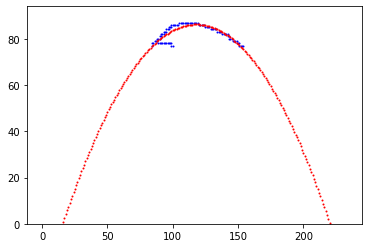

coefficient: [ 0.00000000e+00  2.18765365e+01 -2.59220305e-01  1.36786812e-03
 -2.71177986e-06]
y-intersect: -617.2147712166942


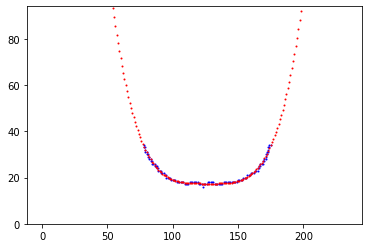

In [32]:
import cv2
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
def get_edge(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    canny = cv2.Canny(blur,30,150)
    return canny
def rm_regression(img,img2,degree):
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #denoise = cv2.fastNlMeansDenoising(gray,h=50)
    ret,thres = cv2.threshold(img2,127,255,cv2.THRESH_BINARY_INV)
    ori = thres.copy()
    ret,thres = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    width = thres.shape[1]
    height = thres.shape[0]
    thres= cv2.bitwise_not(thres)
    thres2=thres.copy()
    thres[18:height,0:width]=0
    thres2[0:60,0:width]=0
    border_data=np.where(thres==255)
    Y_label = border_data[0]
    samples=Y_label.shape[0]
    X=border_data[1].reshape(samples,1)
    regs = LinearRegression()
    feature = PolynomialFeatures(2)
    X_input = feature.fit_transform(X)
    regs.fit(X_input,Y_label)
    print('coefficient:',regs.coef_)
    print('y-intersect:',regs.intercept_)
    
    newX = np.array([i for i in range(width)])
    newX = newX.reshape(newX.shape[0],1)
    newX_input = feature.fit_transform(newX)
    newY = regs.predict(newX_input)
    
    plt.ylim(bottom=0,top=height)
    plt.scatter(X,height-Y_label,color='blue',s=1)
    plt.scatter(newX,height-newY,color='red',s=1)
    plt.show()
    
    border_data2=np.where(thres2==255)
    Y_label2 = border_data2[0]
    samples2=Y_label2.shape[0]
    X2=border_data2[1].reshape(samples2,1)
    regs2 = LinearRegression()
    feature2 = PolynomialFeatures(4)
    X_input2 = feature2.fit_transform(X2)
    regs2.fit(X_input2,Y_label2)
    print('coefficient:',regs2.coef_)
    print('y-intersect:',regs2.intercept_)
    
    newX2 = np.array([i for i in range(width)])
    newX2 = newX2.reshape(newX2.shape[0],1)
    newX_input2 = feature2.fit_transform(newX2)
    newY2 = regs2.predict(newX_input2)
    
    plt.ylim(bottom=0,top=height)
    plt.scatter(X2,height-Y_label2,color='blue',s=1)
    plt.scatter(newX2,height-newY2,color='red',s=1)
    plt.show()
    
    img_cuv=np.zeros_like(ori)
    img_cuv2=np.zeros_like(ori)
    newY = newY.round(0)
    newY2 = newY2.round(0)
    for point in np.column_stack([newY,newX]):
        py=int(point[0])
        px=int(point[1])
        if px<180 and px>77:
            img_cuv[py:height,px]=255 
    for point in np.column_stack([newY2,newX2]):
        py=int(point[0])
        px=int(point[1])
        if px<180 and px>77:
            img_cuv2[0:py,px]=255 
    diff = cv2.absdiff(ori,img_cuv)
    roi=cv2.bitwise_and(img_cuv,img_cuv2)
    #cv2.imshow('2',roi)
    diff = cv2.absdiff(ori,roi)
    denoise = cv2.fastNlMeansDenoising(diff,h=80)
    denoise= cv2.bitwise_not(denoise)
    return denoise
img=cv2.imread('d:/captcha2.PNG')
img_edge = get_edge(img)
#cv2.imshow('edge',img_edge)
result_img=rm_regression(img_edge,img,degree=2)
cv2.imshow('result',result_img)
cv2.imshow('original',img)
cv2.waitKey(0)
cv2.destroyAllWindows()